In [1]:
clear all;

global ipynb = 'ttt-vfun';

source('clearest-nn.m');
source('utils-logging.m');
source('utils-training.m');
source('game-ttt.m');

% log2file(tmp('log'));

##########################################

[winner,s] = play1(@randompolicy, @randompolicy)
oh18 = game2oh18(s)'
oh27 = game2oh27(s)'
play(100, @randompolicy);


ans = THE CLEAREST NEURAL NETWORK FRAMEWORK BY UNDWAD
ans = TIC-TAC-TOE GAME
winner =  1
s =

   0   2   2
   1   1   1
   1   0   2

oh18 =

   0   0   1   0   1   0   0   1   1   0   0   0   0   1   1   0   0   1

oh27 =

 Columns 1 through 26:

  1  0  0  0  0  1  0  0  0  0  1  1  0  1  0  0  1  0  0  0  0  1  0  0  1  0

 Column 27:

  1

playing 100 times randompolicy vs randompolicy
wins = [53 34]
draws = 13


<img align="left" src="assets/reinforce.png">
<img align="left" src="assets/reinforce-baseline.png">

In [14]:
### Q-LEARNING WITH NEURAL NETWORK FUNCTION APPROXIMATION ###

global vmodel epsilon tau gamma policy1 policy2;

function X = nextstates2onehots(s, aaa=actions(s))
    X = map(@(a) game2oh18(game(s,a)), aaa);
end

function a = stochastic_policy(s)
    global vmodel;
    aaa   = actions(s);
    X     = nextstates2onehots(s, aaa);
    [~,Q] = forward(vmodel, X);
    [~,i] = softmaxpick(Q');
    a     = aaa(i);
end

function a = deterministic_policy(s)
    global vmodel;
    aaa   = actions(s);
    X     = nextstates2onehots(s, aaa);
    [~,Q] = forward(vmodel, X);
    [~,i] = max(Q);
    a     = aaa(i);
end

function [a,x] = taustochastic_policy(s)
    global vmodel tau;
    aaa   = actions(s);
    X     = nextstates2onehots(s, aaa);
    [~,Q] = forward(vmodel, X);
    Q    /= tau;
    [~,i] = softmaxpick(Q');
    a     = aaa(i);
    x     = X(:,i);
end

function [a,x] = epsilongreedy_policy(s)
    global vmodel epsilon;
    aaa = actions(s)
    X   = nextstates2onehots(s, aaa);
    if rand() < epsilon
        i     = randi([1 count(aaa)]);
    else
        [~,Q] = forward(vmodel, X);
        [~,i] = max(Q);
    end
    a = aaa(i);
    x = X(:,i);
end

function s = start(agent)
    global policy1;
    s = game();
    if agent == 2
        a = policy1(s);
        s = game(s, a); 
    end
end

function [s, reward, winner] = move(agent, s, a)
    global policy1 policy2;
    s = game(s, a);            # learning player moves
    if iswin(s, a)             # learning player wins
        reward = 1;
        winner = agent;
    elseif isover(s)           # draw
        reward = 0;
        winner = 0;
    elseif player(s) == agent  # invalid move
        error('invalid move');
    else                       # continue
        a = randompolicy(s);   
        s = game(s, a);        # other player moves
        if iswin(s, a)         # other player wins
            reward = -1;
            winner = player(s, a);
        elseif isover(s)       # draw
            reward = 0;
            winner = 0;
        else                   # continue
            reward = 0;
            winner = [];
        end  
    end  
end

global delta_error_signs;

function [winner,err] = episode(agent)
    global vmodel tau gamma;
    winner = [];     # draw: 0, players: 1,2
    X = zeros(18,9); # states as onehot vectors
    P = zeros(9,9);  # valid action probs
    A = zeros(1,9);  # selected actions
    Y = zeros(9,9);  # targets (rewards)
    n = 0;           # number of moves
    s = start(agent);
    do
        x       = game2oh18(s);
        [~,qqq] = forward(vmodel, x);
        aaa     = actions(s);
        pp      = softmax(qqq(aaa) / tau);
        [~,idx] = softmaxpick(pp);
        a       = aaa(idx);
        ppp     = setsome(zeros(9, 1), pp, aaa);
        [s, reward, winner] = move(agent, s, a);
        n     += 1;
        X(:,n) = x;
        P(:,n) = ppp;
        A(:,n) = a;
        y      = setsome(zeros(9, 1), reward, a); 
        Y(:,n) = y;
    until !isempty(winner);
%     X
%     P
%     A
%     Y
    for i = n-1:-1:1
        a       = A(i);
        next_y  = sum(P(:,i+1) .* Y(:,i+1));
        Y(a,i) += gamma*next_y;
    end
    X              = X(:, 1:n);
    Y              = Y(:, 1:n);
%     Y
    [vmodel,Z]     = forward(vmodel, X);
%     Z
    Y              = Z .* (Y == 0) .+ Y;
%     Y
    E              = cost(vmodel, Z, Y);
%     E
    dE             = gradient(vmodel, Z, Y);
%     dE
    [vmodel,ggg,~] = backward(vmodel, Z, dE);
    [vmodel,ggg]   = optimize_gradient(vmodel, ggg, 1);
    new_vmodel     = update(vmodel, ggg);
    err            = mean(E);
    
    [~,Z]          = forward(new_vmodel, X);
    Y              = Z .* (Y == 0) .+ Y;
    E              = cost(new_vmodel, Z, Y);
    delta          = mean(E) - err;

    if delta < 0
        vmodel = new_vmodel;
    end
    
    global delta_error_signs;
    delta_error_signs(sign(delta)+2) += 1;
end

function ratio = iteration(p, n, eps=1e-8)
    global vmodel;
    ERROR = zeros(1,n);
    RATIO = zeros(1,n);
    wins  = [0 0];
    for t = 1:n
        [winner,err] = episode(p);
        if winner > 0 
            wins(winner) += 1; 
        end
        if nnz(wins) == 2
            ratio = wins(p) / wins(other(p));
        else
            ratio = 0;
        end
        ERROR(t) = err;
        RATIO(t) = ratio;
        if t > 1 
            edir = sign(err   - ERROR(t-1));
            rdir = sign(ratio - RATIO(t-1));
        else
            edir = 0;
            rdir = 0;
        end
        gradnorm = getunit(vmodel.optimizers,'gradient_clipping').norm;
        updratio = getunit(vmodel.optimizers,'stats').ratio;        
        showlog(1, 100, 'player %d, episode %d of %d, gradnorm %f, updratio %f, wins %s, error %f %s, ratio %f %s', 
                         p, t, n, gradnorm, updratio, mat2str(wins), err, dir2arrow(edir), ratio, dir2arrow(rdir));
    end
    figure('Position', [0 0 1000 400]);
    hold on;
    plot(1:n, ERROR, 'r');
    plot(1:n, RATIO, 'g');
    legend('objective', 'win ratio')
    title('training history');
end

tau     = 100;
gamma   = 1;
epsilon = 0.1;
policy1 = @randompolicy;
policy2 = @taustochastic_policy;
% vmodel  = model(18, {'maxout', 36}, {'maxout', 18}, {'dense', 1});
% vmodel  = model(18, {'maxout', 36}, {'dense', 1});
vmodel  = model(18, {'dense', 1});
vmodel  = optimization(vmodel, {'adam', 0.1},   {'gradient_clipping', 0.9}, 'stats');
vmodel  = objective(vmodel, 'mse');

printvar('vmodel.num_p');
%printmodel('vmodel');

[winner,s] = play1(@randompolicy, @stochastic_policy)
[winner,s] = play1(@randompolicy, @deterministic_policy)

% play(100, @randompolicy);
% play(100, @randompolicy, @stochastic_policy);
% play(100, @randompolicy, @deterministic_policy);

% delta_error_signs = [0 0 0];

% printstart();
% ratio = iteration(2, 100);
% printend();

% play(100, @randompolicy, @stochastic_policy);
% play(100, @randompolicy, @deterministic_policy);


vmodel.num_p = 19
winner =  1
s =

   2   1   1
   0   1   2
   1   2   0




datestr(starts_at) = 14-Jun-2020 08:11:54

player 2, episode 9992 of 10000, gradnorm 0.597469, updratio 0.019231, wins [5774 3019], error 0.015142 ↑, ratio 0.522861 ↓
datestr(ends_at) = 14-Jun-2020 08:25:27
duration = [0 0 0 0 14 -26.707034]
notifed = 1

playing 100 times randompolicy vs stochastic_policy
wins = [54 37]
draws = 9
playing 100 times randompolicy vs deterministic_policy
wins = [44 51]
draws = 5


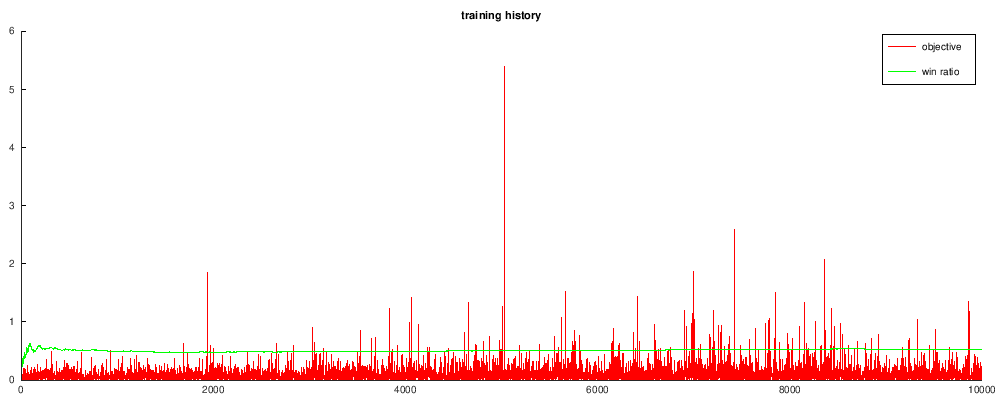

In [5]:
delta_error_signs = [0 0 0];

printstart();
ratio = iteration(2, 10000);
printend(ipynb);

play(100, @randompolicy, @stochastic_policy);
play(100, @randompolicy, @deterministic_policy);

In [ ]:
delta_error_signs = [0 0 0];

printstart();
ratio = iteration(2, 100000);
printend(ipynb);

play(100, @randompolicy, @stochastic_policy);
play(100, @randompolicy, @deterministic_policy);


datestr(starts_at) = 14-Jun-2020 08:25:40

player 2, episode 34225 of 100000, gradnorm 1.015983, updratio 0.017496, wins [19885 10196], error 0.043887 ↓, ratio 0.512748 ↑

In [ ]:
play(100, @randompolicy);
play(100, @randompolicy, @qnnpolicy);

In [ ]:

play(100, @randompolicy);
play(100, @randompolicy, @stochastic_policy);
play(100, @randompolicy, @deterministic_policy);

In [ ]:
%         if isempty(winner)
%             q = qnnestimate(s);
%         else
%             q = 0;
%         end
%         y          = zeros(9,1); 
%         y(prev_a)  = reward + gamma*q;

